### written by Mahad 
### edited by Tanvi Deora on Oct 2
### This code calculates tortoiusity by measuring the 
### displacement over distance measure

In [1]:
from matplotlib import pyplot as plt
import numpy as np
import os
from scipy.fftpack import fft
import pandas as pd
import glob

from scipy import stats
from scipy import signal
from statsmodels.graphics.gofplots import qqplot, qqline
# sns.set(style="ticks")

# load the centroid data

In [3]:
# get centroid data 
Centroids = pd.read_csv(r"./dataFolders/Output/KinematicAnalysis_Final/LowPassFiltered_CentroidAndDistanceData.csv")
Centroids = Centroids.drop(columns = ['Unnamed: 0' , 'Unnamed: 0.1'])
Centroids[['lightLevel', 'mothID']] = Centroids.name.str.split('_', n = 1, expand = True )
Centroids.head()

,name,visit,flower_r,flower_x,flower_y,x,y,x_pixel,y_pixel,x_filtered,y_filtered,cent_x,cent_y,distance,distanceincms,lightLevel,mothID
0,L0.1_c-3_m10,last,74,310,233,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,L0.1,c-3_m10
1,L0.1_c-3_m10,last,74,310,233,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,L0.1,c-3_m10
2,L0.1_c-3_m10,last,74,310,233,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,L0.1,c-3_m10
3,L0.1_c-3_m10,last,74,310,233,0.810811,2.297297,24.0,68.0,23.997467,67.98341,-286.002533,-165.01659,330.193767,11.155195,L0.1,c-3_m10
4,L0.1_c-3_m10,last,74,310,233,1.013514,2.770270,30.0,82.0,24.708767,143.71776,-285.291233,-89.28224,298.935455,10.099171,L0.1,c-3_m10


In [4]:
# remove Problematic Files

listProbs = pd.read_csv(r'G:\My Drive\Mahad\Light Level Experiments\Data Output from Analysis\VideosWithMarkers\FirstLastTroubleVideos_v4\names.csv')
listProbs['name'] = listProbs['name'].str[1:]
listProbs.head()

Centroids['string'] = Centroids.name + '_' + Centroids.visit + 'Visit.csv'

sub_Centroids= Centroids[pd.DataFrame(Centroids.string.tolist()).isin(listProbs.name.tolist()).any(1) == False]
sub_Centroids= sub_Centroids.drop(columns = 'string')

# get the tortuosity measurements

In [5]:
def GetStartStopFrame(x):
    m = np.concatenate(( [True], np.isnan(x), [True] ))  # Mask
    ss = np.flatnonzero(m[1:] != m[:-1]).reshape(-1,2)   # Start-stop limits
    start,stop = ss[(ss[:,1] - ss[:,0]).argmax()]  # Get max interval, interval limits
    return start, stop

In [6]:
def GetLongestFinitePath(x,y):
    ind_s_x, ind_stp_x = GetStartStopFrame(x)
    ind_s_y, ind_stp_y = GetStartStopFrame(y)
    
    strt = max([ind_s_x, ind_s_y])
    stp = min([ind_stp_x, ind_stp_y])
    
    new_x = x[strt: stp]
    new_y = y[strt: stp]
    return new_x, new_y

In [7]:
def Tortuosity(x, time):
    
    t = time/100 # filmed at 100 fps
    Nx = len(x)  #number of points
    Nt = Nx
    Time = t[-1]-t[0]   #total sample time (in seconds)
    fs = Nx/Time   # sample frequency
    TT = 1/fs  #delta t.
 
    meanx = np.mean(x)
    
    #fftxvel is complex with real and imaginary part.
    #Nyquist spacing (first half of Fourier) -- the list of frequencies for which we have Fourier coefficients
    fftx = fft(x-meanx) 
    xf = np.linspace(0.0, 1.0/(2.0*TT), Nx//2)  

    return xf, Nx, fftx

In [8]:
def fullDistance(x, y):
    distance = 0
    for i in np.arange(len(x)-1):
        d = np.sqrt((x[i+1] - x[i])**2 + (y[i+1] - y[i])**2)
        distance+=d
    return distance

In [9]:
chunksize = 40 # number of frames in each chunck

### loop through data 

In [10]:
# all_dfs = pd.DataFrame(data = None)
all_dfs = []

for v, df in sub_Centroids.groupby('visit'):
    for l, sub_df in df.groupby('lightLevel'):
        for m, final_df in sub_df.groupby('mothID'):
#             final_df.reindex()

            # get the x, y coordinates of each track  
            x = final_df.x_filtered.values
            y = final_df.y_filtered.values
            
            raw_x = final_df.x_pixel
            raw_y = final_df.y_pixel

            # get the longest section without NaNs
            new_x, new_y = GetLongestFinitePath(x,y)
            new_raw_x, new_raw_y = GetLongestFinitePath(raw_x, raw_y)
            if not new_x.size:
                print('%s in %s visit and %s has path length of %i' %(m,v,l, len(new_x)))
                continue
                      
#             x = new_x
#             y = new_y            
            time = np.arange(0,len(x)-1, 1)
            
            # chunk the data 
            Displ_tor = []
            fft_amplitude = []

            visit = []
            lightLevel = []
            mothID = []
            
            # do analysis on a sliding window of chunksize
            for idx in np.arange(0,len(new_x)-chunksize, 1):
                
                chunk_x = new_x[idx: idx+chunksize]
                chunk_y = new_y[idx: idx+chunksize]
                
                chunk_raw_x = new_raw_x[idx: idx+chunksize]
                chunk_raw_y = new_raw_y[idx: idx+chunksize]
                chunk_time = time[idx: idx+chunksize]
                
                # Method 1: Distance/displacement
                # the net displacement of the track  
                shortest_path = np.sqrt((chunk_x[-1]- chunk_x[0])**2 \
                                        + (chunk_y[-1]- chunk_y[0])**2) 
                dist = fullDistance(chunk_x, chunk_y)

                # caluclate the path distance ratio
                ratio = dist/shortest_path 
                Displ_tor.append(ratio)

                # Method 2: Spectral analysis   
                xf, Nx, fftx = Tortuosity(chunk_raw_x, chunk_time)
#                 print(xf)
                yf, Ny, ffty = Tortuosity(chunk_raw_y, chunk_time)
                # linear sum of the x and y coordinates amplitude of fft
                sum_xy = ((2.0/Ny * np.abs(ffty[0:Ny//2])) + (2.0/Nx * np.abs(fftx[0:Nx//2])))

                fft_amplitude.append(sum_xy)
            
            length = len(new_x) - chunksize #fill in other deets about this moth
            visit.extend([v]*length)
            mothID.extend([m]*length)
            lightLevel.extend([l]*length)
            
            df1 = pd.DataFrame({'visit': visit,
                   'mothID': mothID,
                   'lightLevel': lightLevel,
                   'Displacement_tor': Displ_tor})
            
            df2 = pd.DataFrame(data = fft_amplitude, columns = np.round(xf, 3))
            df = pd.concat([df1, df2], axis = 1)
            all_dfs.append(df)

In [11]:
# concatenate all dfs together into one single big df
full_df = pd.concat(all_dfs)
#                     , sort = True)
full_df.to_csv('./dataFolders/Output/KinematicAnalysis_Final/TortousityData_Full.csv')

In [12]:
# get averages for each visit
visit = []
light = []
moth = []
disp = []
fft = []

for v, bla in full_df.groupby('visit'):
    for l, blu in bla.groupby('lightLevel'):
        for m, blum in blu.groupby('mothID'):
            disp_tor = blum.Displacement_tor.median()
            left_over = blum.drop(columns = ['visit', 'lightLevel', 'mothID', 'Displacement_tor'])
            med_fft = left_over.median()
            
            visit.append(v)
            light.append(l)
            moth.append(m)
            disp.append(disp_tor)
            fft.append(med_fft)
            
rest_df = pd.DataFrame({'visit': visit, 
                       'lightLevel': light,
                       'mothID': moth,
                       'disp_tor': disp})
med_fft = pd.concat(fft, axis = 1)
med_fft.T

med_df = pd.concat([rest_df, med_fft.T], axis = 1)

In [13]:
med_df.to_csv('./dataFolders/Output/KinematicAnalysis_Final/TortousityData_median.csv')

# plot the tortuosity

In [14]:
import seaborn as sns
from scipy import stats

In [19]:
# Pathways
figpath = r"./dataFolders/Output/KinematicAnalysis_Final/Figures/Tortousity/"

In [16]:
data = pd.read_csv('./dataFolders/Output/KinematicAnalysis_Final/TortousityData_median.csv')
data.head()

,Unnamed: 0,visit,lightLevel,mothID,disp_tor,0.0,2.699,5.398,8.097,10.796,...,26.991,29.69,32.389,35.088,37.787,40.486,43.185,45.884,48.583,51.282
0,0,first,L0.1,c-3_m2,2.382058,5.186962e-14,28.601052,12.271520,8.485338,6.781379,...,31.965877,16.004484,8.348834,6.493295,5.208975,4.293342,4.426778,5.002408,5.516080,9.435503
1,1,first,L0.1,c-3_m20,2.907353,3.144152e-14,33.490180,14.238385,10.645877,8.991478,...,16.215209,9.519412,7.511523,7.365684,6.017381,5.279761,5.415649,5.431269,7.841455,8.163268
2,2,first,L0.1,c-3_m21,2.604811,3.126388e-14,45.307159,17.622315,12.234076,10.158050,...,15.577702,13.450056,6.337152,6.808881,5.580436,6.993249,7.062502,7.580490,11.612458,8.624679
3,3,first,L0.1,c-3_m22,3.419387,2.984279e-14,43.942204,22.167602,15.330309,14.311207,...,29.825169,17.546565,13.617951,11.253984,9.695985,9.772052,10.050328,11.185728,9.148304,19.443699
4,4,first,L0.1,c-3_m23,2.888134,1.634248e-14,42.499261,16.012237,11.459246,9.657710,...,26.071134,14.338412,9.366354,7.503738,6.859627,5.573183,7.110489,8.525365,9.742188,21.160412


In [17]:
w = 7/3
# w = 8
h = w * 2

## path length method

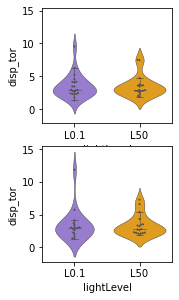

In [20]:
f, ax = plt.subplots(2,1, figsize = (w,h), sharey = True)

i=0

for v, sub in data.groupby('visit'):
    sns.violinplot(x='lightLevel', y='disp_tor', data = sub, 
                   inner = None, 
                   palette=['mediumpurple','orange'], 
                   linewidth = 0.5,
                   ax=ax[i])
    sns.boxplot(x='lightLevel', y='disp_tor', data = sub, 
                width = 0.2,
                linewidth = 0.5,
                fliersize = 0,
                ax=ax[i])
    sns.swarmplot(x='lightLevel', y='disp_tor', data = sub,
                size=2, 
                  color="0.3",
                  linewidth=0,
                  ax=ax[i])
    i+=1
plt.savefig(figpath + 'Displacement-tor.pdf')

In [21]:
low_first = data[(data.lightLevel == 'L0.1') & (data.visit == 'first')].disp_tor.values
high_first = data[(data.lightLevel == 'L50') & (data.visit == 'first')].disp_tor.values

low_last = data[(data.lightLevel == 'L0.1') & (data.visit == 'last')].disp_tor.values
high_last = data[(data.lightLevel == 'L50') & (data.visit == 'last')].disp_tor.values

In [22]:
stats.mannwhitneyu(low_first, high_first)

MannwhitneyuResult(statistic=182.0, pvalue=0.4273532046574666)

In [23]:
stats.mannwhitneyu(low_last, high_last)

MannwhitneyuResult(statistic=148.0, pvalue=0.44096536063897307)

## fft tortuosity

In [24]:
test = data.drop(columns = ['Unnamed: 0', 'visit', 'lightLevel', 'mothID', 'disp_tor'])

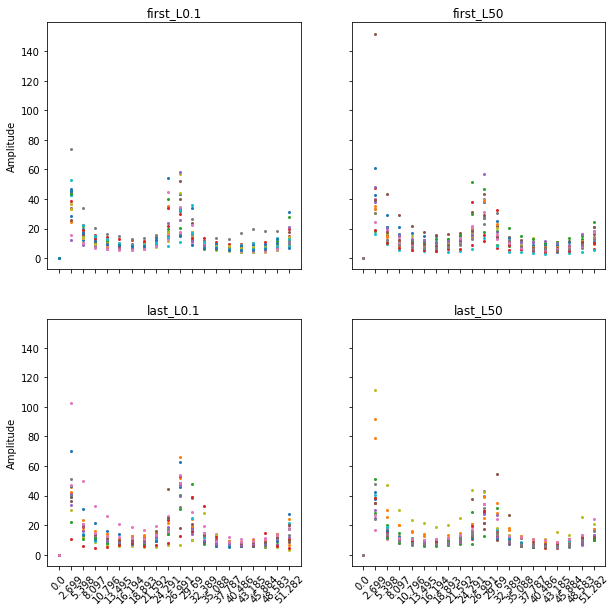

In [27]:
f,ax = plt.subplots(2,2, figsize = (10,10), sharex = True, sharey = True)
ax = ax.ravel()

i = 0
for v, sub in data.groupby('visit'):
    for l, subsub in sub.groupby('lightLevel'):
        test = subsub.drop(columns = ['Unnamed: 0', 'visit', 'lightLevel', 'mothID', 'disp_tor'])
        for index, row in test.iterrows():
            ax[i].plot(row.index, row.values, 'o'
                      , markersize = 2)
            ax[i].set_title(v + '_' + l)
        i+=1

for axis in [ax[2], ax[3]]:
    plt.setp(axis.xaxis.get_majorticklabels(), rotation=45)
for axis in [ax[0], ax[2]]:
    axis.set_ylabel('Amplitude')
#     text(-0.1, 0.5, 'Amplitude', horizontalalignment='center',
#              verticalalignment='center', 
#              rotation=90,
#              transform=axis.transAxes,
#             fontsize = 12)
plt.savefig(figpath + 'fft_rawData.pdf')

In [28]:
low = row.index[1:5]
medium = row.index[5:9]
high = row.index[11:]
low, medium, high

(Index(['2.699', '5.398', '8.097', '10.796'], dtype='object'),
 Index(['13.495', '16.194', '18.893', '21.592'], dtype='object'),
 Index(['29.69', '32.389', '35.088', '37.787', '40.486', '43.185', '45.884',
        '48.583', '51.282'],
       dtype='object'))

In [29]:
low_val = []
med_val = []
high_val = []
visit_l = []
visit_m = []
visit_h = []
lightLevel_l = []
lightLevel_m = []
lightLevel_h = []

for v, sub in data.groupby('visit'):
    for l, subsub in sub.groupby('lightLevel'):
        test = subsub.drop(columns = ['Unnamed: 0', 'visit', 'lightLevel', 'mothID', 'disp_tor'])
        low_freq = list(test.iloc[:,1:5].values.ravel())
        med_freq = list(test.iloc[:,5:9].values.ravel())
        high_freq = list(test.iloc[:,11:].values.ravel())
        
        low_val.extend(low_freq)
        med_val.extend(med_freq)
        high_val.extend(high_freq)
        
        visit_l.extend([v]*len(low_freq))
        lightLevel_l.extend([l]*len(low_freq))
        
        visit_m.extend([v]*len(med_freq))
        lightLevel_m.extend([l]*len(med_freq))
        
        visit_h.extend([v]*len(high_freq))
        lightLevel_h.extend([l]*len(high_freq))

In [30]:
low_fft = pd.DataFrame({'visit' : visit_l,
                    'lightLevel': lightLevel_l,
                    'spectraAmplitude': low_val})

med_fft = pd.DataFrame({'visit' : visit_m,
                    'lightLevel': lightLevel_m,
                    'spectraAmplitude': med_val})

high_fft = pd.DataFrame({'visit' : visit_h,
                    'lightLevel': lightLevel_h,
                    'spectraAmplitude': high_val})

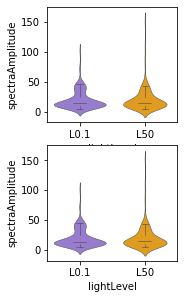

In [31]:
f, ax = plt.subplots(2,1, figsize = (w,h), sharey = True)

i=0

for v, sub in data.groupby('visit'):
    sns.violinplot(x='lightLevel', y='spectraAmplitude', data = low_fft, 
                   inner = None, 
                   palette=['mediumpurple','orange'], 
                   linewidth = 0.5,
                   ax=ax[i])
    sns.boxplot(x='lightLevel', y='spectraAmplitude', data = low_fft, 
                width = 0.2,
                linewidth = 0.5,
                fliersize = 0,
                ax=ax[i])
#     sns.swarmplot(x='lightLevel', y='spectraAmplitude', data = low_fft,
#                 size=2, 
#                   color="0.3",
#                   linewidth=0,
#                   ax=ax[i])
    i+=1
plt.savefig(figpath + 'fft_low.pdf', bbox_inches = 'tight',
    pad_inches = 0)

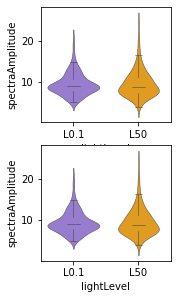

In [32]:
f, ax = plt.subplots(2,1, figsize = (w,h), sharey = True)

i=0

for v, sub in data.groupby('visit'):
    sns.violinplot(x='lightLevel', y='spectraAmplitude', data = med_fft, 
                   inner = None, 
                   palette=['mediumpurple','orange'], 
                   linewidth = 0.5,
                   ax=ax[i])
    sns.boxplot(x='lightLevel', y='spectraAmplitude', data = med_fft, 
                width = 0.2,
                linewidth = 0.5,
                fliersize = 0,
                ax=ax[i])
#     sns.swarmplot(x='lightLevel', y='spectraAmplitude', data = low_fft,
#                 size=2, 
#                   color="0.3",
#                   linewidth=0,
#                   ax=ax[i])
    i+=1
plt.savefig(figpath + 'fft_med.pdf', bbox_inches = 'tight',
    pad_inches = 0)

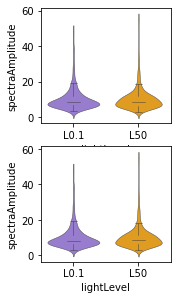

In [33]:
f, ax = plt.subplots(2,1, figsize = (w,h), sharey = True)

i=0

for v, sub in data.groupby('visit'):
    sns.violinplot(x='lightLevel', y='spectraAmplitude', data = high_fft, 
                   inner = None, 
                   palette=['mediumpurple','orange'], 
                   linewidth = 0.5,
                   ax=ax[i])
    sns.boxplot(x='lightLevel', y='spectraAmplitude', data = high_fft, 
                width = 0.2,
                linewidth = 0.5,
                fliersize = 0,
                ax=ax[i])
#     sns.swarmplot(x='lightLevel', y='spectraAmplitude', data = low_fft,
#                 size=2, 
#                   color="0.3",
#                   linewidth=0,
#                   ax=ax[i])
    i+=1
plt.savefig(figpath + 'fft_high.pdf', bbox_inches = 'tight',
    pad_inches = 0)

In [34]:
string = ['low', 'med', 'high']
for data, s in zip([low_fft, med_fft, high_fft], string):
    low_first = data[(data.lightLevel == 'L0.1') & (data.visit == 'first')].spectraAmplitude.values
    high_first = data[(data.lightLevel == 'L50') & (data.visit == 'first')].spectraAmplitude.values

    low_last = data[(data.lightLevel == 'L0.1') & (data.visit == 'last')].spectraAmplitude.values
    high_last = data[(data.lightLevel == 'L50') & (data.visit == 'last')].spectraAmplitude.values
    
    print(s)
    print('first visit')
    print(stats.mannwhitneyu(low_first, high_first))
    print('last visit')
    print(stats.mannwhitneyu(low_last, high_last))

low
first visit
MannwhitneyuResult(statistic=2929.0, pvalue=0.3684565990449329)
last visit
MannwhitneyuResult(statistic=2335.0, pvalue=0.31951936316876306)
med
first visit
MannwhitneyuResult(statistic=2685.0, pvalue=0.11441958779542988)
last visit
MannwhitneyuResult(statistic=2087.0, pvalue=0.06641655440907264)
high
first visit
MannwhitneyuResult(statistic=13979.0, pvalue=0.08032693920939143)
last visit
MannwhitneyuResult(statistic=11347.0, pvalue=0.09781541043285608)
